# Data Exploration and Understanding

1. **Dataset statistics**
    1. How many instances of solar panels are present in the dataset?
    2. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

2. **Calculate the statistics of the area of solar panels in meters** (Read label readme carefully for this question)
    1. What method was used to compute the area (in meters) for a single instance?
    2. What is the mean area and standard deviation?
    3. Plot the histogram of areas. What do you observe?

Found 2542 label files in '/workspace/deepfake/Object_Labels/labels_native'.
Total number of solar panel instances: 29625

Distribution of annotations per image (images with X annotations):
1      81
2     167
3     221
4     218
5     217
     ... 
74      5
75      1
76      2
77      2
78      1
Name: count, Length: 74, dtype: int64


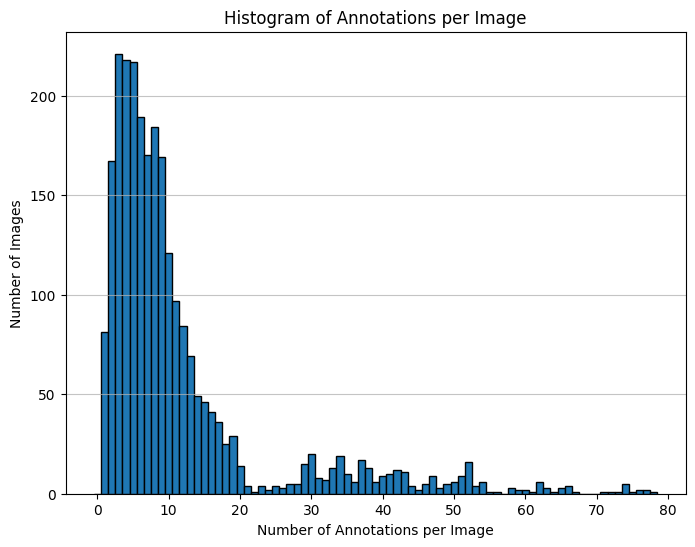


Mean area of solar panels: 191.5178 m^2
Standard deviation of area: 630.7003 m^2


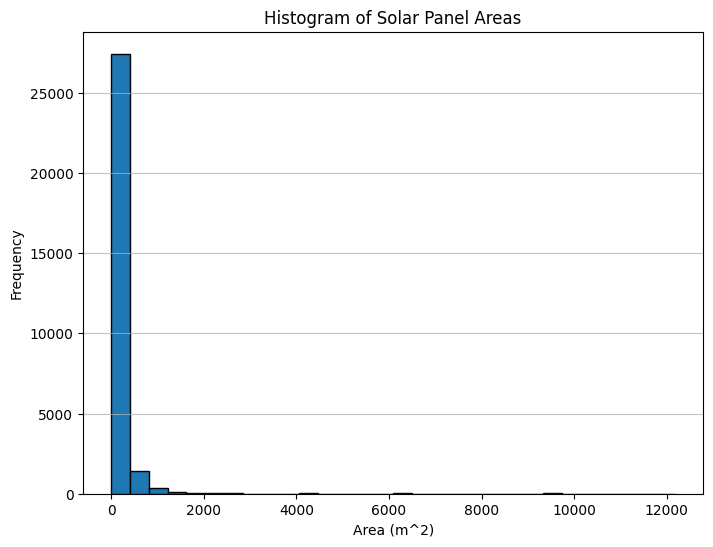

In [2]:
import os
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The Object_Labels directory has two subfolders: 'labels_hd' and 'labels_native'
# For this assignment, I'm focusing on the native resolution images
labels_dir_native = "/workspace/deepfake/Object_Labels/labels_native"  

# For native image chips, each chip is 416 x 416 pixels
CHIP_SIZE = 416          
# Each pixel represents 0.31 meters on the ground
PIXEL_RESOLUTION = 0.31   


# Compute the Physical Area of a Solar Panel Annotation
def compute_area(x_width_norm, y_height_norm, chip_size=CHIP_SIZE, pixel_resolution=PIXEL_RESOLUTION):
    """
    I am using this function to compute the actual area (in m²) of a solar panel based on its normalized width and height
    The steps are:
      1. Convert the normalized width and height to pixel values (using CHIP_SIZE)
      2. Convert those pixel dimensions to meters (using PIXEL_RESOLUTION)
      3. Multiply width and height (in meters) to get the area
    """
    width_pixels = x_width_norm * chip_size
    height_pixels = y_height_norm * chip_size
    width_meters = width_pixels * pixel_resolution
    height_meters = height_pixels * pixel_resolution
    return width_meters * height_meters

# I use glob to get all the .txt files in my native labels folder
label_files_native = glob.glob(os.path.join(labels_dir_native, "*.txt"))
if len(label_files_native) == 0:
    print(f"Found 0 label files in '{labels_dir_native}'. Please check the path or add the label files.")
    sys.exit(0)

print(f"Found {len(label_files_native)} label files in '{labels_dir_native}'.")

annotations_per_image = []  # Number of solar panel annotations per image
all_areas = []              # Computed area for each annotation

# Loop over each native label file
for label_file in label_files_native:
    with open(label_file, 'r') as f:
        lines = f.readlines()

    num_annotations = 0
    
    for line in lines:
        line = line.strip()
        if not line:
            continue  
        # I expect each line to follow: category, x_center, y_center, x_width, y_height
        parts = line.split()
        if len(parts) < 5:
            continue  # If the line doesn't have enough info, I skip it
        try:
            x_width_norm = float(parts[3])
            y_height_norm = float(parts[4])
        except ValueError:
            continue  
        area = compute_area(x_width_norm, y_height_norm)
        all_areas.append(area)
        num_annotations += 1
    annotations_per_image.append(num_annotations)

# Calculate and Display Dataset Statistics
if len(annotations_per_image) == 0:
    print("No annotations found in any native label file.")
    sys.exit(0)

# I am converting the annotation counts to a pandas Series for easy analysis
annotations_series = pd.Series(annotations_per_image)

# Here I compute the total number of solar panel instances across the dataset
total_instances = annotations_series.sum()
print(f"Total number of solar panel instances: {total_instances}")

# Distribution of annotations per image
annotation_counts = annotations_series.value_counts().sort_index()
print("\nDistribution of annotations per image (images with X annotations):")
print(annotation_counts)

# Histogram to show the number of annotations in each image
plt.figure(figsize=(8, 6))
plt.hist(annotations_per_image, bins=range(0, max(annotations_per_image) + 2), align='left', edgecolor='black')
plt.xlabel("Number of Annotations per Image")
plt.ylabel("Number of Images")
plt.title("Histogram of Annotations per Image")
plt.grid(axis='y', alpha=0.75)
plt.show()

# Solar Panel Area Analysis
# I am converting my list of computed areas to a NumPy array for analysis
areas_array = np.array(all_areas)

# Here I calculate the mean and standard deviation of the solar panel areas
mean_area = np.mean(areas_array)
std_area = np.std(areas_array)
print(f"\nMean area of solar panels: {mean_area:.4f} m^2")
print(f"Standard deviation of area: {std_area:.4f} m^2")

# Histogram to visualize the distribution of solar panel areas
plt.figure(figsize=(8, 6))
plt.hist(areas_array, bins=30, edgecolor='black')
plt.xlabel("Area (m^2)")
plt.ylabel("Frequency")
plt.title("Histogram of Solar Panel Areas")
plt.grid(axis='y', alpha=0.75)
plt.show()


# Data Exploration and Understanding

## 1. Dataset Statistics

### 1.1 Total Number of Solar Panel Instances
After processing the native resolution label files (located in the "labels_native" subfolder), I found that there are **29,625 solar panel instances** in total. These instances are spread across 2,542 image chips. On average, each image chip has roughly 11–12 annotations. This indicates that while many images contain only a few panels, there are some images with a much higher density of panels.

### 1.2 Distribution of Labels Per Image
I computed the value counts for the number of annotations per image, and here’s what I observed:
- Many images have very few panels: for example, 81 images have just 1 annotation, 167 images have 2, 221 images have 3, and so on.
- There is a long tail in the distribution, with some images having up to 78 annotations.
  
This right-skewed distribution tells me that most images show a modest number of solar panels, but there are a few images where the panels are extremely dense. Such an imbalance is important to consider for model training since the model might see a lot more sparse scenes than very dense ones. I might need to apply data augmentation or balanced sampling to ensure the model learns well from both types of scenes.

## 2. Statistics of Solar Panel Areas

### 2.1 Method for Computing the Area
To compute the physical area of each solar panel, I followed these steps:

1. **Normalized Dimensions:** Each annotation provides normalized width and height values.
2. **Convert to Pixels:** I multiplied these normalized values by 416 (the chip size) to convert them into pixel dimensions.
3. **Convert to Meters:** I then converted these pixel dimensions into meters using the pixel resolution of 0.31 m/pixel.
4. **Calculate the Area:** Finally, I multiplied the width (in meters) by the height (in meters) to obtain the area in square meters.

This process is summarized by the formula:

area (m²) = (normalized_width × 416 × 0.31) × (normalized_height × 416 × 0.31)

This ensures that the areas I compute are in real-world units (square meters), which is critical for understanding the physical scale of the solar panels.

### 2.2 Mean Area and Standard Deviation
After applying the above method to all annotations, I calculated:
- **Mean area:** ~191.52 m²  
- **Standard deviation:** ~630.70 m²

The mean suggests that, on average, the solar panel areas are moderately sized. However, the very high standard deviation tells me that there is a huge variability in the sizes. In other words, while many panels are relatively small (likely residential installations), a few are extremely large (probably from large solar farms), which drives up the overall variability.

### 2.3 Histogram of Solar Panel Areas
When I plotted the histogram of the solar panel areas, I made these observations:
- **Clustering at Lower Values:**  
  The bulk of the solar panel areas are concentrated in the lower end of the scale. This suggests that most of the panels are small in size.

- **Long Tail:**  
  There is a noticeable long tail in the histogram, where a few instances extend well above 1,000 m². This long tail represents the larger solar installations, which are less common but significantly larger than the typical residential panels.

- **Implication:**  
  The histogram confirms that the dataset has a mix of small and large solar panels. This variance is critical because it means any detection model needs to be robust across different scales.

## Conclusions

1. **Richness and Diversity:**  
   The dataset is rich with nearly 30,000 labeled solar panel instances across 2,542 images. It covers a wide range of scenarios, from sparse residential setups to very dense commercial solar farms.

2. **Annotation Density Imbalance:**  
   Most images have a small number of annotations, but a few images have very high counts. This skewed distribution suggests that during model training, I might need to use techniques like data augmentation or balanced sampling to ensure that the model is exposed to both sparse and dense scenes effectively.

3. **High Variability in Panel Sizes:**  
   With a mean area of about 191.52 m² and a high standard deviation of 630.70 m², the dataset exhibits substantial variability in solar panel sizes. This is indicative of a mix between small residential panels and large-scale solar installations. Any model built on this data must account for such scale differences, likely by incorporating multi-scale detection methods.

4. **Implications for Model Training:**  
   Given the wide range in both the number of panels per image and the sizes of the panels themselves, it's important to carefully design the training pipeline. Techniques to handle multi-scale detection and address the imbalance in annotation densities will be crucial for developing a robust model.

Overall, these insights give me a solid understanding of the dataset's characteristics and help me plan the next steps in building and evaluating a solar panel detection model.
